# Load data

In [1]:
import gdown
import zipfile
import os

# ID file từ đường link bạn cung cấp
file_id = '1Y_6TfutXPg42HwMCZBlrjSZSxy0vEpC2'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'data_project.zip'

# 1. Tải file về bộ nhớ tạm của Colab
print("Đang tải file từ Google Drive...")
gdown.download(url, output, quiet=False)

# 2. Giải nén file
if os.path.exists(output):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        # Giải nén vào thư mục 'data_content'
        zip_ref.extractall('data/raw')
    print("Giải nén thành công vào thư mục 'data_content'")
else:
    print("Lỗi: Không tìm thấy file đã tải.")

Đang tải file từ Google Drive...


Downloading...
From (original): https://drive.google.com/uc?id=1Y_6TfutXPg42HwMCZBlrjSZSxy0vEpC2
From (redirected): https://drive.google.com/uc?id=1Y_6TfutXPg42HwMCZBlrjSZSxy0vEpC2&confirm=t&uuid=52cd6c73-2749-40f0-a024-38a711d78fcb
To: /content/data_project.zip
100%|██████████| 1.07G/1.07G [00:12<00:00, 83.8MB/s]


Giải nén thành công vào thư mục 'data_content'


In [2]:
from pathlib import Path

PROJECT_ROOT = Path("").resolve()
DATA_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

SAMPLE_DIR = DATA_DIR / "samples"

TRAIN_DIR = DATA_DIR / "train"
NORMAL_DIR = TRAIN_DIR / "normal"
SPOOF_DIR = TRAIN_DIR / "spoof"

DEV_DIR = DATA_DIR / "dev"
DEV_NORMAL_DIR = DEV_DIR / "normal"
DEV_SPOOF_DIR = DEV_DIR / "spoof"

TEST_DIR = DATA_DIR / "test"
TEST_NORMAL_DIR = TEST_DIR / "normal"
TEST_SPOOF_DIR = TEST_DIR / "spoof"

(np.float64(-0.5), np.float64(1079.5), np.float64(1919.5), np.float64(-0.5))

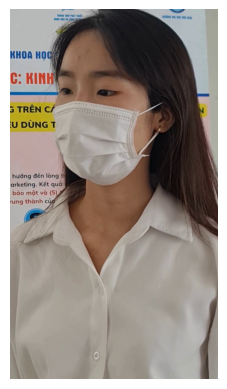

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = list(NORMAL_DIR.glob("*.jpg"))[5]
img = Image.open(img_path)
plt.imshow(img)
plt.axis("off")


In [4]:
normal_samples = list(NORMAL_DIR.glob("*.jpg"))
spoof_samples = list(SPOOF_DIR.glob("*.jpg"))
len(normal_samples), len(spoof_samples)

(1432, 1368)

In [5]:
dev_normal_samples = list(DEV_NORMAL_DIR.glob("*.jpg"))
dev_spoof_samples = list(DEV_SPOOF_DIR.glob("*.jpg"))
len(dev_normal_samples), len(dev_spoof_samples)

(551, 524)

In [6]:
for img_path in NORMAL_DIR.glob("*.jpg"):
  img = Image.open(img_path)
  if img.size[0] < 448 or img.size[1] <= 448:
    print(f"{img_path}: {img.size}")

/content/data/raw/train/normal/1366_1.jpg: (320, 576)
/content/data/raw/train/normal/1404_2.jpg: (320, 576)
/content/data/raw/train/normal/1877_2.jpg: (368, 656)
/content/data/raw/train/normal/422_1.jpg: (384, 852)
/content/data/raw/train/normal/422_2.jpg: (384, 852)
/content/data/raw/train/normal/340_4.jpg: (320, 576)
/content/data/raw/train/normal/1433_3.jpg: (368, 656)
/content/data/raw/train/normal/340_2.jpg: (320, 576)
/content/data/raw/train/normal/645_4.jpg: (320, 576)
/content/data/raw/train/normal/1345_3.jpg: (416, 852)
/content/data/raw/train/normal/422_3.jpg: (384, 852)
/content/data/raw/train/normal/1877_1.jpg: (368, 656)
/content/data/raw/train/normal/340_1.jpg: (320, 576)
/content/data/raw/train/normal/55_1.jpg: (320, 576)
/content/data/raw/train/normal/55_3.jpg: (320, 576)
/content/data/raw/train/normal/1401_1.jpg: (240, 480)
/content/data/raw/train/normal/340_3.jpg: (320, 576)
/content/data/raw/train/normal/1139_4.jpg: (320, 576)
/content/data/raw/train/normal/1877_3.jp

In [7]:
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import Compose # type: ignore
from torchvision import transforms # type: ignore

class LivenessDataset(Dataset):
  LABEL_MAP = {"normal": 0, "spoof": 1}

  def __init__(self, data_dir: Path,
                transform: Compose | None=None):
    self.samples: list[tuple[Path, int]] = []
    self.transform = transform

    for class_dir in sorted(data_dir.iterdir()):
      if not class_dir.is_dir():
        continue

      label = self.LABEL_MAP[class_dir.name]
      for img_path in sorted(class_dir.glob("*.jpg")):
        self.samples.append((img_path, label))


  def __len__(self):
    return len(self.samples)

  def __getitem__(self, index: int):
    path, label = self.samples[index]
    image = Image.open(path).convert("RGB")

    if self.transform:
      image = self.transform(image)
    else:
      transform = Compose([
        transforms.Resize((260, 260)),
        transforms.ToTensor()
      ])
      image = transform(image)

    return image, label



In [8]:
from pathlib import Path
from typing import Literal
from torchvision.transforms import Compose # type: ignore
from torch.utils.data import Dataset, DataLoader


class LivenessDataLoader:
  def __init__(self, train_path: Path,
                dev_path: Path,
                test_path: Path,
                samples_path: Path,
                transform: Compose | None=None,
                batch_size=32,
                shuffle=True):
      self.samples_path = samples_path
      self.train_path = train_path
      self.dev_path = dev_path
      self.test_path = test_path
      self.transform = transform
      self.batch_size = batch_size
      self.shuffle = shuffle

  def get_dataloader(self, dataset: Dataset) -> DataLoader:
      return DataLoader(dataset, batch_size=self.batch_size, shuffle=self.shuffle)

  def setup(self, stage: Literal['samples','fit', 'test']):
      if stage == 'fit':
          self.train_dataset = LivenessDataset(self.train_path, self.transform)
          self.dev_dataset = LivenessDataset(self.dev_path, self.transform)

      elif stage == 'samples':
          self.samples_dataset = LivenessDataset(self.samples_path, self.transform)
      elif stage == 'test':
          self.test_dataset = LivenessDataset(self.test_path, self.transform)

  def get_train_loader(self):
      return self.get_dataloader(self.train_dataset)

  def get_dev_loader(self):
      return self.get_dataloader(self.dev_dataset)

  def get_samples_loader(self):
      return self.get_dataloader(self.samples_dataset)

  def get_test_loader(self):
      return self.get_dataloader(self.test_dataset)

# Preprocessing

In [9]:
import os
from pathlib import Path


for folder in TRAIN_DIR.iterdir():
  print(folder)
  print(folder.name)

os.listdir(TRAIN_DIR)

/content/data/raw/train/normal
normal
/content/data/raw/train/spoof
spoof


['normal', 'spoof']

In [10]:


load_provider = LivenessDataLoader(
  train_path=TRAIN_DIR,
  dev_path=DEV_DIR,
  test_path=TEST_DIR,
  samples_path=SAMPLE_DIR
)


load_provider.setup("test")
test_loader = load_provider.get_test_loader()
load_provider.setup('fit')
train_loader = load_provider.get_train_loader()
dev_loader = load_provider.get_dev_loader()

In [11]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([32, 3, 260, 260]) torch.Size([32])


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LivenessCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # (B,128,1,1)
        )

        self.classifier = nn.Linear(128, 2)

    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)        # (B,128)
        logits = self.classifier(x)
        return logits


In [13]:
from torchvision import models

class LivenessDetectionModel(nn.Module):

    def __init__(self, num_classes=2, pretrained=True, dropout=0.35):
        super().__init__()


        # Load EfficientNet-B2 (larger model, better for recall)
        self.backbone = models.efficientnet_b2(pretrained=False)
        num_features = self.backbone.classifier[1].in_features  # 1408 for B2
        self.backbone.classifier = nn.Identity()

        # Enhanced classifier head for better discrimination
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_features, 768),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(768),
            nn.Dropout(p=dropout + 0.05),
            nn.Linear(768, 384),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(384),
            nn.Dropout(p=dropout),
            nn.Linear(384, num_classes)
        )

        # Load pretrained weights manually if requested
        if pretrained:
            try:
                import torch.utils.model_zoo as model_zoo
                state_dict = model_zoo.load_url(
                    'https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth',
                    map_location='cpu',
                    check_hash=False  # Skip hash validation
                )
                # Load only backbone weights (not classifier)
                backbone_state = {k.replace('module.', ''): v for k, v in state_dict.items()
                                    if not k.startswith('classifier')}
                self.backbone.load_state_dict(backbone_state, strict=False)
                print("✓ Loaded EfficientNet-B2 pretrained weights")
            except Exception as e:
                print(f"⚠ Warning: Could not load pretrained weights: {e}")
                print("  Continuing with random initialization...")


    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output

In [14]:
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, precision_score, recall_score, roc_auc_score


def compute_metrics(y_true, y_pred, y_prob):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred, pos_label=1)
    metrics['recall'] = recall_score(y_true, y_pred, pos_label=1)
    metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
    metrics['avg_precision'] = average_precision_score(y_true, y_prob)
    metrics['f1_score'] = f1_score(y_true, y_pred, pos_label=1)
    return metrics

In [15]:
import numpy as np
import torch


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0.0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        # Check if validation loss is nan
        if np.isnan(val_loss):
            self.trace_func("Validation loss is NaN. Ignoring this epoch.")
            return

        if self.best_val_loss is None:
            self.best_val_loss = val_loss
        elif val_loss < self.best_val_loss - self.delta:
            # Significant improvement detected
            self.best_val_loss = val_loss
            self.counter = 0  # Reset counter since improvement occurred
        else:
            # No significant improvement
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [16]:
from tqdm.auto import tqdm


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    pbar = tqdm(loader, desc="Train", leave=False)

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.long().to(device)

        optimizer.zero_grad()
        logits = model(images)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    return total_loss / len(loader)


In [17]:
from typing import Literal

@torch.no_grad()
def evaluate(model, stage: Literal["Test", "Val"], loader, criterion, device):
    model.eval()
    total_loss = 0.0

    all_labels = []
    all_preds = []
    all_probs = []

    pbar = tqdm(loader, desc=stage, leave=False)

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.long().to(device)

        logits = model(images)          # (B, 2)
        loss = criterion(logits, labels)
        total_loss += loss.item()

        probs = torch.softmax(logits, dim=1)   # (B, 2)
        preds = torch.argmax(probs, dim=1)     # (B,)

        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())
        all_probs.append(probs[:, 1].cpu())    # prob of class 1

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    y_prob = torch.cat(all_probs).numpy()

    metrics = compute_metrics(y_true, y_pred, y_prob)
    return total_loss / len(loader), metrics


In [18]:
!pip install mlflow -q

In [19]:
import torch.nn as nn
import mlflow

NUM_EPOCHS = 5
ETA_MIN = 1e-4

# Fix for 'database is locked' error: Configure MLflow tracking URI for improved SQLite concurrency.
# Assuming mlflow.db is directly in /content/ based on kernel state.
mlflow.set_tracking_uri("sqlite:////content/mlflow.db?journal_mode=WAL&timeout=30000")
mlflow.set_experiment("Liveness Baseline")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = LivenessCNN().to(device)
model = LivenessDetectionModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS,
                                                     eta_min=ETA_MIN)
early_stopping = EarlyStopping(patience=5, delta=0.01, verbose=True, path='best_model_checkpoint.pt') # Added path for checkpoint


with mlflow.start_run():
    mlflow.log_params({"learning_rate": 1e-3, "batch_size": 32, "epochs": NUM_EPOCHS})

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

        train_loss = train_one_epoch(
            model,
            train_loader,
            optimizer,
            criterion,
            device
        )

        val_loss, val_metrics = evaluate(
            model,
            "Val",
            dev_loader,
            criterion,
            device
        )

        scheduler.step()

        # Corrected EarlyStopping logic:
        # 1. Update early stopping internal state (counter, best_val_loss, early_stop flag)
        early_stopping(val_loss, model)

        # 2. Save checkpoint if validation loss has improved (compared to the best saved loss)
        # The `early_stopping.val_loss_min` is initialized to infinity, so first improvement will save.
        # The `save_checkpoint` method in the provided `EarlyStopping` class updates `self.val_loss_min`.
        if val_loss < early_stopping.val_loss_min: # Check if current val_loss is better than the best saved one
            early_stopping.save_checkpoint(val_loss, model)

        # 3. Check if early stopping criteria has been met
        if early_stopping.early_stop:
            print("Early stopping triggered. Training interrupted.")
            break

        mlflow.log_metrics({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_acc": val_metrics["accuracy"],
            "val_precision": val_metrics["precision"],
            "val_recall": val_metrics["recall"],
            "val_roc_auc": val_metrics["roc_auc"],
            "val_avg_precision": val_metrics["avg_precision"],
            "val_f1_score": val_metrics["f1_score"]
        })

        print(
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Acc: {val_metrics['accuracy']:.4f}"
        )
    mlflow.pytorch.log_model(model, name="model")


2025/12/27 15:40:14 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/27 15:40:14 INFO mlflow.store.db.utils: Updating database tables
2025/12/27 15:40:14 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/27 15:40:14 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/27 15:40:14 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/27 15:40:14 INFO alembic.runtime.migration: Will assume non-transactional DDL.
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)

✓ Loaded EfficientNet-B2 pretrained weights

Epoch 1/5


Train:   0%|          | 0/88 [00:00<?, ?it/s]

Val:   0%|          | 0/34 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.289225).  Saving model ...
Train Loss: 0.2327 | Val Loss: 0.2892 | Val Acc: 0.9219

Epoch 2/5


Train:   0%|          | 0/88 [00:00<?, ?it/s]

Val:   0%|          | 0/34 [00:00<?, ?it/s]

Validation loss decreased (0.289225 --> 0.267234).  Saving model ...
Train Loss: 0.0918 | Val Loss: 0.2672 | Val Acc: 0.9209

Epoch 3/5


Train:   0%|          | 0/88 [00:00<?, ?it/s]

Val:   0%|          | 0/34 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 5
Validation loss decreased (0.267234 --> 0.266375).  Saving model ...
Train Loss: 0.0595 | Val Loss: 0.2664 | Val Acc: 0.9395

Epoch 4/5


Train:   0%|          | 0/88 [00:00<?, ?it/s]

Val:   0%|          | 0/34 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 5
Train Loss: 0.0392 | Val Loss: 0.2700 | Val Acc: 0.9312

Epoch 5/5


Train:   0%|          | 0/88 [00:00<?, ?it/s]

Val:   0%|          | 0/34 [00:00<?, ?it/s]

Validation loss decreased (0.266375 --> 0.227698).  Saving model ...
Train Loss: 0.0115 | Val Loss: 0.2277 | Val Acc: 0.9460


2025/12/27 15:49:09 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/12/27 15:49:19 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.24.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.24.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [28]:
test_loss, test_metrics = evaluate(
            model,
            "Test",
            test_loader,
            criterion,
            device
        )



Test:   0%|          | 0/30 [00:00<?, ?it/s]

Test Loss: 0.1828 | Test Acc: {'accuracy': 0.9465811965811965, 'precision': 0.9511111111111111, 'recall': 0.9385964912280702, 'roc_auc': np.float64(0.9876918859649123), 'avg_precision': np.float64(0.9895448359358991), 'f1_score': 0.9448123620309051}


In [30]:
from pprint import pprint

pprint(f"Test Loss: {test_loss:.4f} | \n"
f"Test Acc: {test_metrics}")

('Test Loss: 0.1828 | \n'
 "Test Acc: {'accuracy': 0.9465811965811965, 'precision': 0.9511111111111111, "
 "'recall': 0.9385964912280702, 'roc_auc': np.float64(0.9876918859649123), "
 "'avg_precision': np.float64(0.9895448359358991), 'f1_score': "
 '0.9448123620309051}')


In [24]:
!pip install mlflow pyngrok -q
!npm install -g localtunnel -q

⠙⠹⠸⠼⠴⠦⠧
changed 22 packages in 2s
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧

In [26]:
import urllib.request
password = urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip()
print(f"BƯỚC 1: Copy Password này: {password}")

import subprocess
subprocess.Popen(["mlflow", "ui", "--host", "0.0.0.0", "--port", "5000"])

print("BƯỚC 2: Click vào link bên dưới và dán Password vào:")
!npx localtunnel --port 5000

BƯỚC 1: Copy Password này: 34.87.117.195
BƯỚC 2: Click vào link bên dưới và dán Password vào:
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸your url is: https://violet-symbols-decide.loca.lt
^C


In [21]:
torch.save(
    {
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
    },
    "liveness_cnn.pt"
)
